In [1]:
# install.packages("partykit")
# install.packages("pre")
library("partykit")
source("SimData.r")
library("party")
library(MASS)
library("glmertree")
library("caret") # importance and rfe
source("SimData.r")
library("randomForest")
library("rpart")
library("fuzzyforest")
library("WGCNA")
library("pre")

Warning message:
"package 'party' was built under R version 3.6.1"Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.6.1"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
"package 'sandwich' was built under R version 3.6.1"
Attaching package: 'party'

The following objects are masked from 'package:partykit':

    cforest, ctree, ctree_control, edge_simple, mob, mob_control,
    node_barplot, node_bivplot, node_boxplot, node_inner, node_surv,
    node_terminal, varimp

Warning message:
"package 'glmertree' was built under R version 3.6.1"Loading required package: lme4
Warning message:
"package 'lme4' was built under R version 3.6.1"Loading required package: Matrix

Attaching package: 'lme4'

The following object is masked 

# data

In [2]:
# training data
n <- 100 # number of patients
T <-  5 # number of observations per patients

set.seed(100)

data <- sim_quad(n,T)


#add PC
data$PC1 = (prcomp(data[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data$PC2 = (prcomp(data[,101:200], scale = TRUE)$x)[,1]
data$PC3 = (prcomp(data[,201:300], scale = TRUE)$x)[,1]

# add time_squared
data$time2 = (data$time)^2

# # add group*time interaction
# data$time_G1 = data$time * data$group1 # b1, time*group1
# data$time_G2 = data$time * data$group2 # b2
# data$time2_G1 = (data$time)^2 * data$group1 # b1 time^2 * group1
# data$time2_G2 = (data$time)^2 * data$group2 # b2


head(data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V400,rand_int,time,treatment,patient,y,PC1,PC2,PC3,time2
-0.9193970,0.4416402,-1.6874364,-1.2282920,-1.4719190,-0.7258681,-1.0007080,-0.5809589,-0.6480068,-1.0717893,...,-1.15259948,0.7452864,1,1,1,8.466967,-9.982050,-13.036248,-4.1435250,1
-0.8763958,-0.9931904,-0.5903482,-0.8938970,-1.2517455,-0.4072832,-1.8738281,-1.2849527,-1.0130168,-0.3346373,...,0.46416071,0.7452864,2,1,1,-3.849688,-10.748425,2.111788,1.5080274,4
-0.6046310,-0.3771163,-0.8634822,-0.9587687,-0.8106843,0.2184991,-1.4998981,-0.8083261,-0.2937366,-0.7714238,...,0.72893247,0.7452864,3,1,1,7.850598,-5.392401,-3.561392,-0.3662763,9
0.1238469,-1.4196072,-0.6497125,-0.6689533,-1.2245386,-1.3911706,-0.3050343,-0.9567550,-1.2421426,-0.8961609,...,0.41061745,0.7452864,4,1,1,6.635803,-9.805820,-17.196481,8.2508071,16
-1.5415618,-0.9090509,-0.5699499,-1.4404816,-0.9707221,-1.2020829,-1.1336156,-0.1288167,-1.5646634,-0.2275436,...,-1.46114720,0.7452864,5,1,1,6.361511,-10.347417,1.481799,1.3901661,25
-0.3119151,-0.7531623,-0.3931515,-0.3771317,-0.7265423,-0.6114486,-1.1590108,-0.7932671,-0.8573822,-0.5079328,...,-0.01890809,0.5078654,1,1,2,15.281902,-6.948794,-3.737099,3.1874258,1


In [3]:
# testing data
n_test <- 30 # number of patients
T <-  5 # number of observations per patients

set.seed(101)

data_test <- sim_quad(n_test, T)


#add PC: only for testing; In our final algorithm we don't need PC of test data
data_test$PC1 = (prcomp(data_test[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data_test$PC2 = (prcomp(data_test[,101:200], scale = TRUE)$x)[,1]
data_test$PC3 = (prcomp(data_test[,201:300], scale = TRUE)$x)[,1]

# add time_squared
data_test$time2 = (data_test$time)^2

# add group*time interaction
# data_test$time_G1 = data_test$time * data_test$group1 # b1, time*group1
# data_test$time_G2 = data_test$time * data_test$group2 # b2
# data_test$time2_G1 = (data_test$time)^2 * data_test$group1 # b1 time^2 * group1
# data_test$time2_G2 = (data_test$time)^2 * data_test$group2 # b2

head(data_test)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V400,rand_int,time,treatment,patient,y,PC1,PC2,PC3,time2
0.41663309,0.89240235,1.2629480,1.35291620,0.78580562,0.91050948,1.2608898,2.0417540,0.97435430,1.7156164,...,-0.7614910,0.4642566,1,1,1,28.603395,-9.8491137,5.968512,-2.558372,1
0.08024653,0.57003328,-0.1347279,-0.44784976,1.00955878,0.03346909,0.4219186,0.1418229,0.16793241,0.2035047,...,-0.3939817,0.4642566,2,1,1,14.977940,-1.6259945,-2.471658,5.568015,4
-0.81029373,-0.67737774,-1.6411519,-0.13767377,0.02395855,-0.73805381,-0.7207957,-1.4724358,-1.01200706,-0.3608902,...,-1.7282629,0.4642566,3,1,1,-9.676654,10.9995969,7.273782,-5.765773,9
-0.25222627,-0.04714545,-0.5320209,-0.46777622,-0.18780604,-0.37878976,-0.1241675,0.7347177,-0.46405268,-0.6129418,...,0.2629397,0.4642566,4,1,1,4.185493,2.3082627,-7.090120,2.413063,16
0.63851459,-0.08559017,0.2423125,0.01722303,-0.47790233,-0.52711203,0.7971484,-0.5635968,0.76329485,0.0910973,...,-1.6155898,0.4642566,5,1,1,34.502940,0.1015183,3.899663,3.328615,25
0.28422991,0.32789942,1.4553146,0.52947934,0.61138130,1.29291519,1.3110730,0.7731834,-0.05554493,1.2974275,...,-0.1172696,0.1960028,1,1,2,25.357101,-8.1165143,27.319959,11.288165,1


In [4]:
# Methods for extracting names of splitting features used in a tree
# tree: a tree object; data: the train or test set
get_split_names = function(tree,data){
    # path: the string that contains all the node information
    paths <- pre:::list.rules(tree, removecomplements = FALSE)
    vnames = names(data)
    # the regex for a variable
    # tomatch = paste(paste(var,"<="),"|",paste(var,">"),sep="")
    # match to tomatch in path
    tmp = vnames[sapply(sapply(vnames, FUN = function(var) grep(paste(paste(var,"<="),"|",paste(var,">"),sep=""), paths)), length) > 0]
    return (tmp)
}

# Automatic version

In [5]:
start_time <- Sys.time()

data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

# the correspondance betweeen feature names and colors
colors = net$colors # it is a string vector with names (that is the name is V1)
# Get a list with the first element being all the names of first groups and so on
# all the names of modules
module_names = unique(colors) # all colors name

# a vector with name(index) = names of modules and value = the corresponding names
# of features (like a dictionary)
module_dic = list()
for (i in 1:length(module_names)){
    module_dic[[module_names[i]]] = names(colors[colors==module_names[i]])
}
# module_dic

In [6]:
##### eigengene: here we may not need this since we have time as regressor ####
# # extract eigengenes and rename the column.
# # The eigengene(1st pricinpal component) is L2 normalized
# eigengene = net$MEs
# # eigengene
# # add eigengen to training data
# for (name in module_names){
#     if (name == "grey"){
#         next
#     }
#     eigen_name = paste("ME",name,sep="")
#     data[[eigen_name]] = eigengene[[eigen_name]]
# }
# # head(data)
##### end eigengene ####

In [7]:
imp_var = list() # used to store the names of important features
cluster_var = "patient" # the name should be specified by the users

# For each module including grey, use model tree as following:
# use its time and time2 as regression variables
# use all features in the module + treatment as splitting variables
# Finally, use all the chosen features for splitting and regression variables

# for non-grey groups
for (name in module_names){
    
    # in the formula, add treatment as split_var
    split_var = module_dic[[name]] # if don't add treatment
    split_var = c(module_dic[[name]],"treatment")
    
    # use time and time2 as regressor
    regress_var = c("time2","time")
    
    # Formula for lmtree: use PC as regressors
    Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                paste(split_var,collapse = "+")))
    
    # fit the tree
    mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
    
    #extract important features
    imp_var[[length(imp_var)+1]] = get_split_names(mytree$tree,data)
    
#     plot(mytree)
#     flush.console()
#     cat("\n",get_split_names(mytree$tree,data),"\n")
    # to print the error, we have to add PC to test data
#     print(mean((predict(mytree,newdata=data_test)-data_test$y)**2))
}


imp_var 

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


[[1]]
[1] "V1"  "V2"  "V3"  "V93"

[[2]]
character(0)

[[3]]
character(0)

[[4]]
[1] "V301"

In [8]:
# the variables selected from all the modules
final_var = imp_var[[1]]
if (length(imp_var)>1){
    for (i in 2:length(imp_var)){
    final_var = c(final_var,imp_var[[i]])
 }
}
final_var

[1] "V1"   "V2"   "V3"   "V93"  "V301"

In [9]:
regress_var = c("time2","time")
split_var = c(final_var,"treatment")
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=8) 
final_var = get_split_names(mytree$tree,data)
final_var

[1] "V1"   "V2"   "V3"   "V93"  "V301"

In [10]:
# use the final features as split&regression variables
split_var = c(final_var,"treatment")
regress_var = c("time2","time",split_var)
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 

fixed-effect model matrix is rank deficient so dropping 4 columns / coefficients
fixed-effect model matrix is rank deficient so dropping 4 columns / coefficients


Time difference of 10.66683 secs

[1] 37.22704

$patient


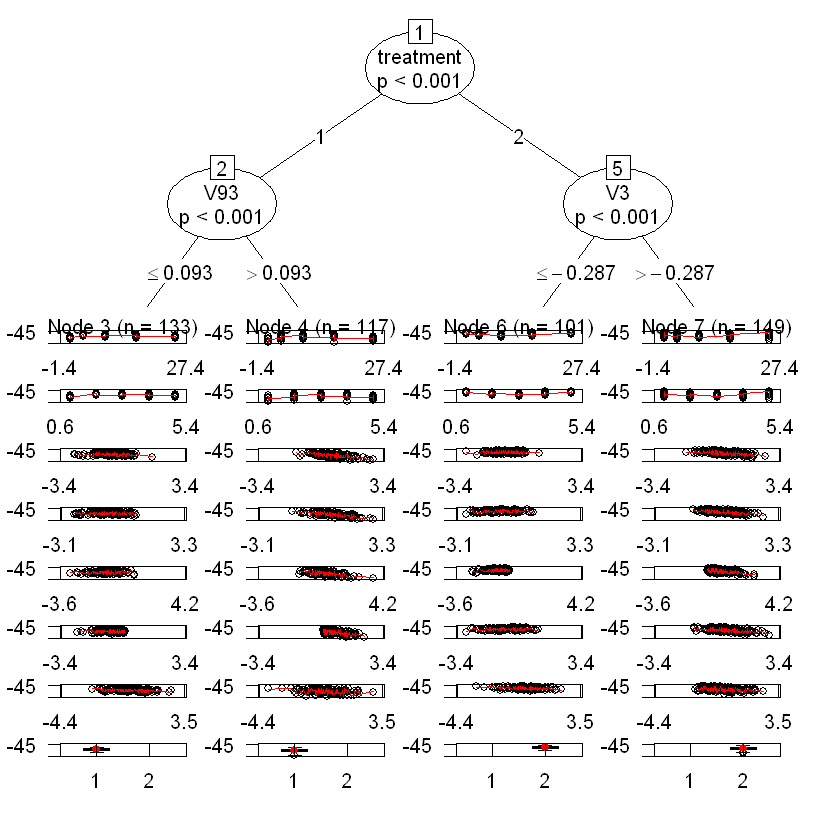

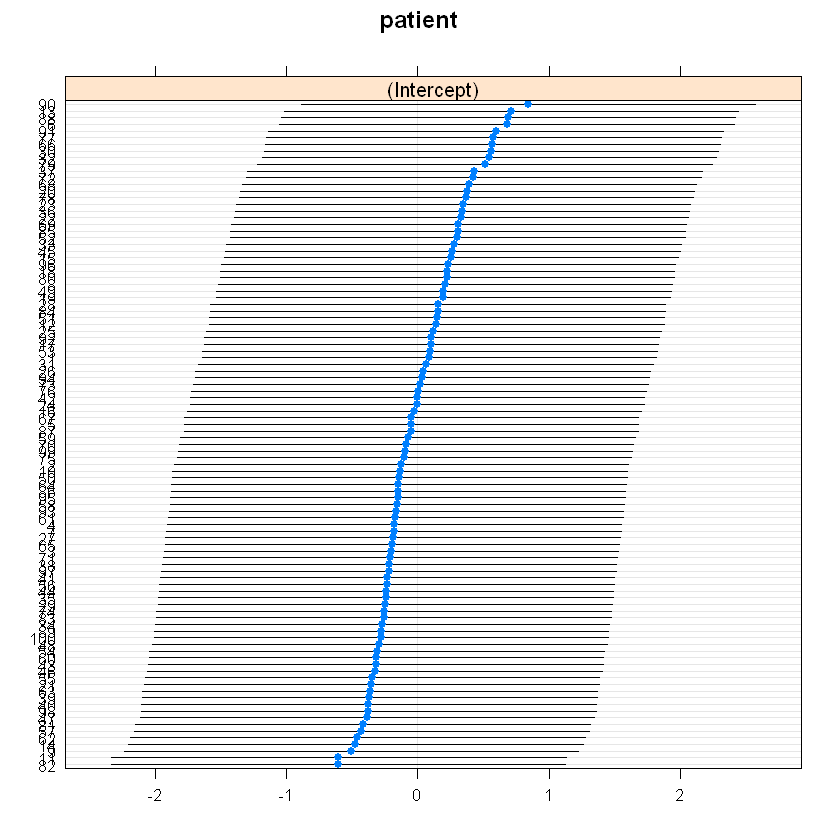

In [12]:
end_time <- Sys.time()
end_time - start_time # running time

mean((predict(mytree,newdata=data_test)-data_test$y)**2)
plot(mytree)

# Model tree: step by step version

fixed-effect model matrix is rank deficient so dropping 4 columns / coefficients
fixed-effect model matrix is rank deficient so dropping 4 columns / coefficients


   user  system elapsed 
   0.31    0.00    0.31 

[1] 36.66417

[1] "V3"  "V93"

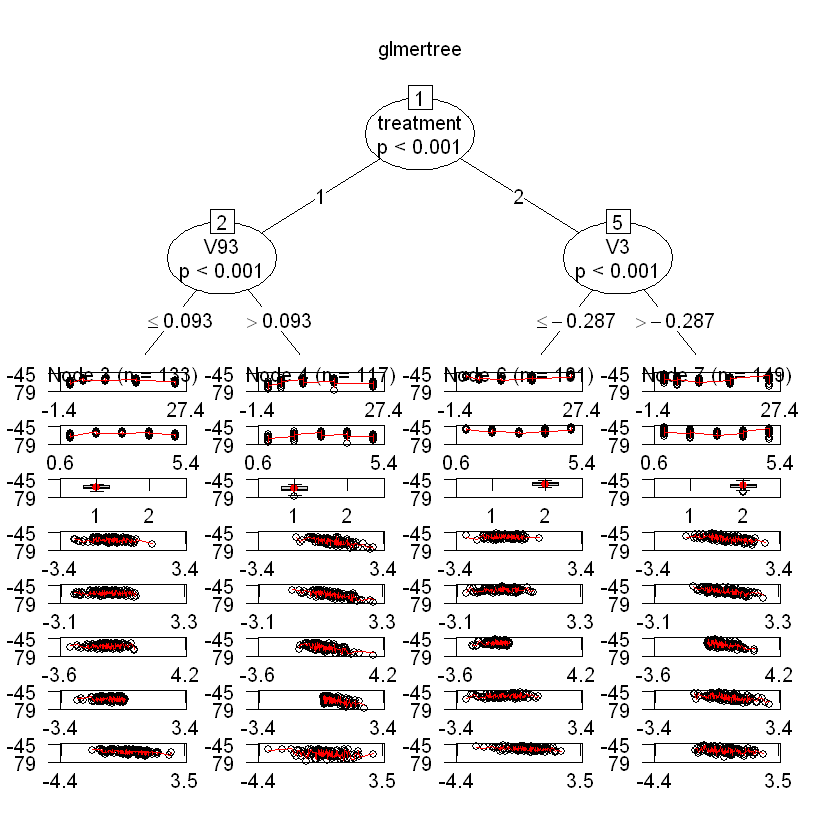

In [13]:
# split_var = c(paste("V",301:400,sep=""))
# split_var = c("treatment",paste("V",1:100,sep=""))
# split_var = c("treatment")
split_var = c("treatment",paste("V",c(1,2,3,93,301),sep=""))
# split_var = c("treatment",paste("V",c(1,2,3,301,302,303),sep="")) # correct

# regress_var = c("time2","time")
# regress_var = c("V1")
# regress_var = c("treatment","time","time2")
regress_var = c("time2","time",split_var)

cluster_var = "patient"
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
# Formula

system.time({
    # you can change alpha = 0.2
    lmm_tree <- lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
})
# mean square error on test data
mean((predict(lmm_tree,newdata=data_test,re.form=NA)-data_test$y)**2)

# the selected features
get_split_names(lmm_tree$tree,data)

# coef(lmm_tree)
plot(lmm_tree,which="tree",main = "glmertree")

In [14]:
Formula

y ~ time2 + time + treatment + V1 + V2 + V3 + V93 + V301 | patient | 
    treatment + V1 + V2 + V3 + V93 + V301

In [15]:
coef(lmm_tree)

,(Intercept),time2,time,treatment2,V1,V2,V3,V93,V301
3,42.81414,4.987817,-29.78004,NA,3.652193,-0.4693114,-1.712127,-1.1851001,4.871974
4,45.81307,5.173390,-31.68475,NA,6.183070,4.0324310,6.580569,1.5639061,4.873731
6,-51.00472,-5.370108,31.33908,NA,3.836581,-2.6028628,-3.897864,-0.1906334,4.619385
7,-44.77145,-4.497094,27.41259,NA,3.748250,5.5320579,8.502266,0.2057241,5.442048


In [16]:
# random effect (here is just intercept)
# ranef(lmm_tree)

# Benchmark

   user  system elapsed 
 126.91    0.70  131.44 

[1] 82.17368

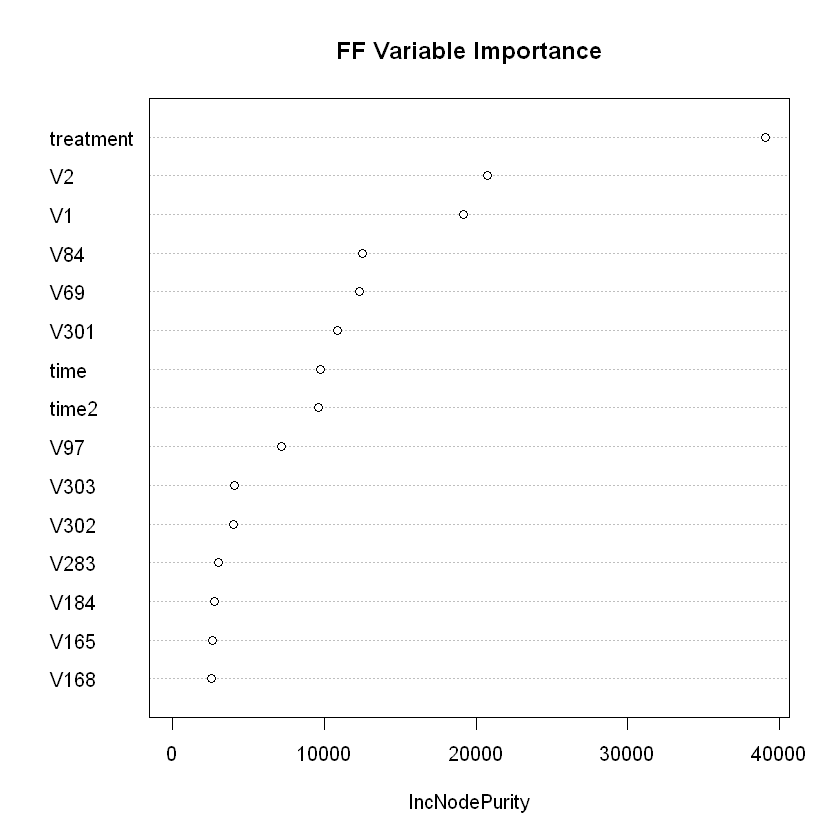

In [17]:
# since treatment is categorical, we cannot include it in WGCNA

system.time({
data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

var = c(paste("V",1:400,sep=""),"time","time2","treatment")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))
    
net$colors[["time"]] = "grey"
net$colors[["time2"]] = "grey"
net$colors[["treatment"]] = "grey"
    
# var = paste("V",1:400,sep="")
# Formula = as.formula(paste("y~",paste(var,collapse = "+")))
    


ff_fit = ff(Formula,data = data,module_membership=net$colors,
        screen_params = screen_control(min_ntree = 500),
        select_params = select_control(min_ntree = 500,number_selected = 15), 
        final_ntree = 5000, num_processors = 1)        
})
mean((predict(ff_fit,new_data=data_test)-data_test$y)**2)
varImpPlot(ff_fit$final_rf,type=2,main="FF Variable Importance")

   user  system elapsed 
  17.45    0.03   17.73 

[1] 107.9648

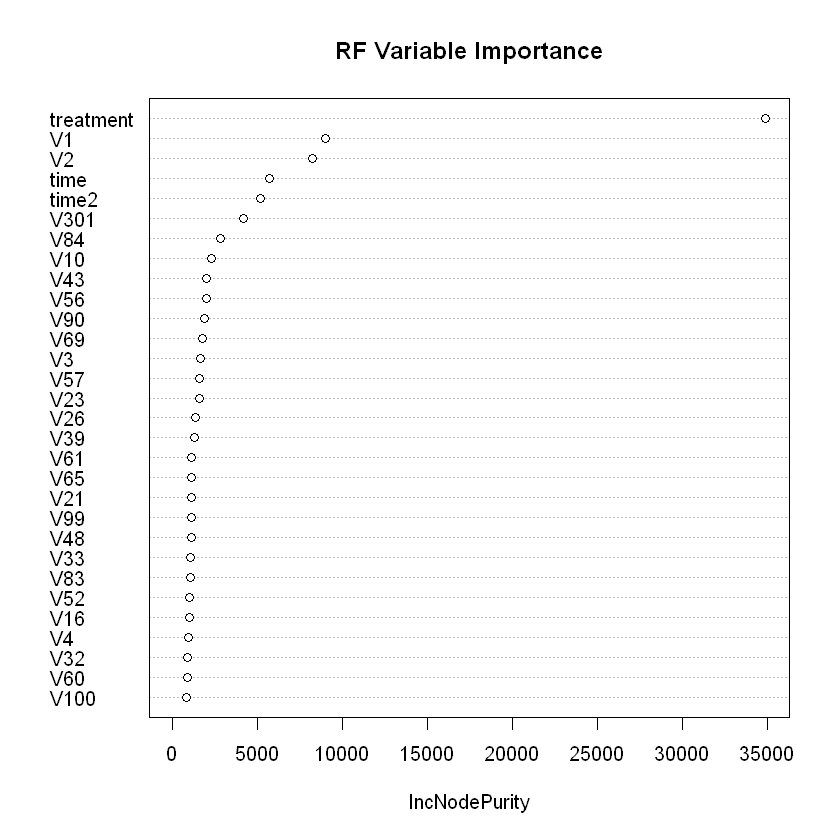

In [18]:
# Random Forest
var = c(paste("V",1:400,sep=""),"time","time2","treatment")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))
system.time({
#     set.seed(20)
    rf <- randomForest(Formula,data)
})
mean((predict(rf,newdata=data_test)-data_test$y)**2)
varImpPlot(rf,type=2,main="RF Variable Importance")